<a href="https://colab.research.google.com/github/jkworldchampion/Military_CodingStudy/blob/main/deeplearning/computer_vision_tf2_ch3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NoteBook 1 : CNN 기초 연산 살펴보기

In [1]:
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/Colab_Notebooks/Machine_learning/book/computer_vision_tf2/dl-vision/Chapter03

/content/drive/MyDrive/Colab_Notebooks/Machine_learning/book/computer_vision_tf2/dl-vision/Chapter03


In [3]:
%matplotlib inline
import tensorflow as tf
import matplotlib
from matplotlib import pyplot as plt
from skimage import io

## Setup

In [4]:
image = io.imread("./res/bird_pic_by_benjamin_planche.png")   # 예시 이미지를 하나 불러온다.

Image shape: (680, 608)


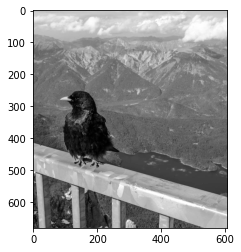

In [5]:
print("Image shape: {}".format(image.shape))
plt.imshow(image, cmap=plt.cm.gray)

우리는 이 이미지를 TensorFlow operations에 넣기 위해, Tensor로 변환할 것이다:

In [6]:
image = tf.convert_to_tensor(image, tf.float32, name="input_image")

Tensorflow의 기본적인 연산들은 대부분 배치 묶음의 차원을 갖고 있기 때문에 다음과 같이 변환 시킬 것이다.

In [7]:
image.shape  # 현재 사진의 벡터

TensorShape([680, 608])

In [8]:
image = tf.expand_dims(image, axis=0)  # 텐서의 0차원을 확장한다.
image.shape

TensorShape([1, 680, 608])

비슷하게, 우리는 현재 gray-scale의 데이터를 갖고 있기 때문에 RGB가 아니다. 따라서 한 차원 더 확장시켜준다.

In [9]:
image = tf.expand_dims(image, axis=-1) # we expand our tensor, adding a dimension at position 0
print("Tensor shape: {}".format(image.shape))

Tensor shape: (1, 680, 608, 1)


## Convolution

2장에서 본 것과 같이**image convolution**을 수행하는 함수는 `tf.nn.conv2()`이다.  
우리는 이번 챕터에서의 그림3과 4를 만들때도 사용할 것이다.

그림 3에서, 우리는 주로 Blur이미지(Gaussian blur)에 사용되는 3*3 filter (or kernel)를 정의할 것이다.

In [10]:
kernel = tf.constant([[1 / 16, 2 / 16, 1 / 16],
                      [2 / 16, 4 / 16, 2 / 16],
                      [1 / 16, 2 / 16, 1 / 16]], tf.float32, name="gaussian_kernel")

그러나 컨볼루션 계층은 filter의 tensor가 ***(k, k, D, N)*** 모양이어야 한다. 우리의 경우 ***D=1*** and ***N=1***이지만, 우리는 이러한 값들을 명시적으로 표현하기 위해 커널을 재구성할 필요가 있다:

In [11]:
print(kernel.shape)
kernel

(3, 3)


<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0.0625, 0.125 , 0.0625],
       [0.125 , 0.25  , 0.125 ],
       [0.0625, 0.125 , 0.0625]], dtype=float32)>

In [12]:
kernel = tf.expand_dims(tf.expand_dims(kernel, axis=-1), axis=-1)  # 차원 확장

In [13]:
kernel.shape

TensorShape([3, 3, 1, 1])

커널로 이미지를 필터링하려면 이제 `tf.nn.conv2()`를 호출하기만 하면 된다.

In [14]:
blurred_image = tf.nn.conv2d(image, kernel, strides=[1, 1, 1, 1], padding="SAME")

기본적으로 TensorFlow 2에서 사용하는 *eager execution*는 작업 결과를 즉시 계산하여 덮어쓴다.

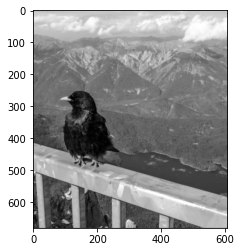

In [15]:
blurred_res = blurred_image.numpy()
# 첫번째 이미지를 택해, 차원을 되돌려준다.
blurred_res = blurred_res[0, ..., 0]

plt.imshow(blurred_res, cmap=plt.cm.gray)

새의 깃털 부분을 보면 Blur가 잘 된 것을 확인할 수 있다.

그림 4에선 ***contour detection***(윤곽선 검출)을 할 것이다. 이 kernel은 다음과 같이 정의할 수 있다.

In [16]:
kernel = tf.constant([[-1, -1, -1],
                      [-1,  8, -1],
                      [-1, -1, -1]], tf.float32, name="edge_kernel")  # 윤곽선을 검출할 kernel
kernel = tf.expand_dims(tf.expand_dims(kernel, axis=-1), axis=-1)  # 차원을 확장해준다.

이번에는 더 큰 stride를 사용하여 이것이 결과 텐서에 어떤 영향을 미치는지 보자.

(340, 304)


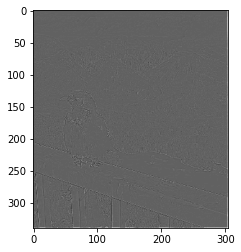

In [17]:
edge_image = tf.nn.conv2d(image, kernel, strides=[1, 2, 2, 1], padding="SAME")
edge_res = edge_image.numpy()[0, ..., 0]   # 차원을 원래대로 돌려주기
plt.imshow(edge_res, cmap=plt.cm.gray)
print(edge_res.shape)

자세히 보면, 이미지의 테두리가 흰색이다. 이는 커널에 의해 윤곽선으로 감지된 제로 패딩(패딩 "SAME"을 선택했기 때문에)에 의해 발생한다. 실제로 이미지를 패드하지 않으면 사라진다.

(339, 303)


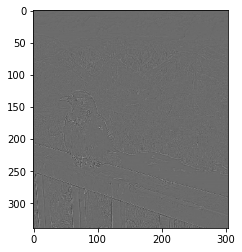

In [18]:
edge_image = tf.nn.conv2d(image, kernel, strides=[1, 2, 2, 1], padding="VALID")
edge_res = edge_image.numpy()[0, ..., 0]   # 차원을 원래대로 돌려주기
plt.imshow(edge_res, cmap=plt.cm.gray)
print(edge_res.shape)  # 개수가 하나씩 빠져 있음을 볼 수 있다.

padding 옵션을 SAME으로 설정하면 시작과 같은 사이즈의 결과가 출력이 되고, VALID로 설정하면 내부에 있는 데이터만 사용하기 때문에 데이터 유실의 문제가 생길 수 있다.

## Pooling

For ***max-pooling*** and ***average-pooling***, 이들은 각각 창의 최댓, 평균 연산을 적용한다.

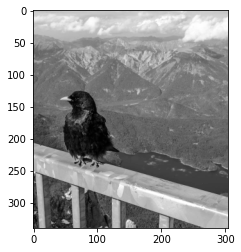

In [19]:
avg_pooled_image = tf.nn.avg_pool(image, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")
avg_res = avg_pooled_image.numpy()[0, ..., 0]
plt.imshow(avg_res, cmap=plt.cm.gray)

이러한 하이퍼 파라미터로, 평균 풀링은 ksize를 [1, 2, 2, 1]로 설정하여, 옆의 원소와의 평균을 계산한다.

이제는 max-pooling을 해보자. 

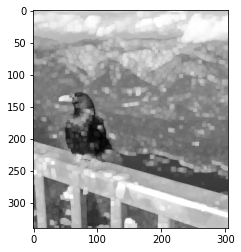

In [20]:
max_pooled_image = tf.nn.max_pool(image, ksize=[1, 10, 10, 1], strides=[1, 2, 2, 1], padding="SAME")
max_res = max_pooled_image.numpy()[0, ..., 0]
plt.imshow(max_res, cmap=plt.cm.gray)

ksize를 매우 큰 10으로 설정하여, 어떻게 작동하는지 알아봤다.

## Conclusion

앞에서 제시한 fully-connected layer에 이러한 작업을 추가하면,  
 이제 다음 노트의 주제가 될 첫 번째 CNN을 구축할 수 있는 도구가 갖춰졌다.

# NoteBook 2 : 텐서플로2와 케라스로 CNN 만들고 학습시키기

In [21]:
import tensorflow as tf
print(tf.__version__)

2.8.2


## Preparing the Data

In [22]:
num_classes = 10  # 0부터 9까지의 숫자
img_rows, img_cols, img_ch = 28, 28, 1   # 이미지의 크기 벡터
input_shape = (img_rows, img_cols, img_ch)

In [23]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # 0부터 1까지로 변환

x_train = x_train.reshape(x_train.shape[0], *input_shape)  # *을 붙이면 tuple로 압축.
x_test = x_test.reshape(x_test.shape[0], *input_shape)

11501568/11490434 [==============================] - 0s 0us/step


## Buliding and Training LeNet-5

keras를 이용해 CNN을 구성해보자.

### Instantating Convolutional Layers

이전 노트에서 컨볼루션을 수행하였지만, NN에서는 필터를 **훈련**시켜야 하며, **bais**와 **activation function**을 추가해야한다.  
그러므로 우리는 1장에서 fully-connected layer에서 했던것 처럼 Convolution Operation을 `Layer`안으로 넣어야한다.  
Tensorflow2/Keras는 확장할 수 있는 `tf.keras.Layer` 클래스를 제공한다.  
 이러한 Convolution Layer을 어떻게 세분화하는지 다음에서 볼 수 있다:

In [24]:
class SimpleConvolutionLayer(tf.keras.layers.Layer):
    
    def __init__(self, num_kernels=32, kernel_size=(3, 3), strides=(1, 1), use_bias=True):
        """
        Initialize the layer.
        :param num_kernels:    Number of kernels for the convolution
        :param kernel_size:    Kernel size (H x W)
        :param strides:        Vertical and horizontal stride as list
        :param use_bias:       Flag th add a bias after convolution / before activation
        """
        # First, we have to call the 'Layer' super __init__(), as it initializes hidden mechanisms:
        super().__init__()
        # Then we assign the parameters:
        self.num_kernels = num_kernels
        self.kernel_size = kernel_size
        self.strides = strides
        self.use_bias = use_bias

    def bulid(self, input_shape):
        """
        Build the layer, initializing its parameters according to the input shape.
        This function will be internally called the first time the layer is used, though
        it can also be manually called.
        :param input_shape:     Input shape the layer will receive (e.g. B x H x W x C)
        """
        # We are provided with the input shape here, so we know the number of input channels:
        num_input_channels = input_shape[-1]  # assuming shape format BHWC  # 나중에 다시 확인해보기

        # Now We know how the shape of the tensor representing the kernels should be:
        kernels_shape = (*self.kernel_size, num_input_channels, self.num_kernels)

        # For this example, we initialize the filters with values picked from a Glorot distribution:
        glorot_uni_initializer = tf.initializers.GlorotUniform()
        self.kernels = self.add_weight(name='kernels',
                                       shape=kernels_shape,
                                       initializer=glorot_uni_initializer,
                                       trainable=True)  # and we make the variable trainable.

        if self.use_bias:   # If bias should be added, we initialize its variable too:
            self.bias = self.add_weight(name='bias',
                                        shape=(self.num_kernels,),
                                        initializer='random_normal',  # e.g., using normal distribution.
                                        trainable=True)
            
    def call(self, inputs):
        """
        Call the layer and perform its operations on the input tensors
        :param inputs:  Input tensor
        :return:        Output tensor
        """
        # We perform the convolution:
        z = tf.nn.conv2d(inputs, self.kernels, strides=[1, *self.strides, 1], padding='VALID')

        if self.use_bias:  # we add the bias if requested:
            z = z + self.bias
        # Finally, we apply the activation function (e.g. ReLU):
        return tf.nn.relu(z)

    def get_config(self):
        """
        Helper function to define the layer and its parameters.
        :return:        Dictionary containing the layer's configuration
        """
        return {'num_kernels': self.num_kernels,
                'kernel_size': self.kernel_size,
                'strides': self.strides,
                'use_bias': self.use_bias}



대부분의 텐서플로우 수학 연산(e.g. `tf.maths` 및 `tf.nn`)은 이미 프레임워크에 의해 정의된 미분들을 가지고 있다. 그러므로 우리는 그것의 역방향 전파를 수동으로 정의할 필요가 없다.  
따라서 방금 구현한 컨볼루션 레이어는 완전히 작동 가능하며, 바로 CNN 내에서 사용할 수 있다.

### Implementing LeNet-5

LeNet-5는 7개의 계층(2 conv, 2 max-pool, 3 FC + 1 helper layer to flatten the feature maps before the FC)으로 이루어진 간단한 CNN이다.  
  
아래에서, 우리는 `tf.keras.Model`클래스를 어떻게 확장할 수 있을 지 알아볼 것이다.

In [25]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [26]:
class LeNet5(Model):
    def __init__(self, num_classes):
        """
        Initialize the model.
        :param num_classes:     Number of classes to predict from
        """
        super(LeNet5, self).__init__()
        # We instantiate the various layers composing LeNet-5:
        # self.conv1 = SimpleConvolutionLayer(6, kernel_size=(5, 5))
        # self.conv2 = SimpleConvolutionLayer(16, kernel_size=(5, 5))
        # ... or using the existing and (recommended) Conv2D class:
        self.conv1 = Conv2D(6, kernel_size=(5, 5), padding='same', activation='relu')
        self.conv2 = Conv2D(16, kernel_size=(5, 5), activation='relu')
        self.max_pool = MaxPooling2D(pool_size=(2, 2))
        self.flatten = Flatten()
        self.dense1 = Dense(120, activation='relu')
        self.dense2 = Dense(84, activation='relu')
        self.dense3 = Dense(num_classes, activation='softmax')
        
    def call(self, inputs):
        """
        Call the layers and perform their operations on the input tensors
        :param inputs:  Input tensor
        :return:        Output tensor
        """
        x = self.max_pool(self.conv1(inputs))        # 1st block
        x = self.max_pool(self.conv2(x))             # 2nd block
        x = self.flatten(x)
        x = self.dense3(self.dense2(self.dense1(x))) # dense layers
        return x


### Classiyfing MNIST with a CNN


In [27]:
model = LeNet5(num_classes)
model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

`tf.keras.Model`은 모든 기능을 갖고 있다. 예를 들어 `model.summary()`를 통해 우리는 모델의 요약본을 볼 수 있다.

In [28]:
# We can call `model.summary()` only if the model was built before. 
# It is normally done automatically at the first use of the network,
# inferring the input shapes from the samples the network is given.
# For instance, the command below would build the network (then use it for prediction):
_ = model.predict(x_test[:10])

# But we can build the model manually otherwise, providing the batched
# input shape ourselves:
batched_input_shape = tf.TensorShape((None, *input_shape))
model.build(input_shape=batched_input_shape)

# Method to visualize the architecture of the network:
model.summary()

Model: "le_net5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  156       
                                                                 
 conv2d_1 (Conv2D)           multiple                  2416      
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  48120     
                                                                 
 dense_1 (Dense)             multiple                  10164     
                                                           

훈련을 시작하기 전에 Keras의 callback을 인스턴스화 한다:

In [29]:
callbacks = [
    # (`val_loss`)이 3회이상 개선되지 않는다면 끝낸다:
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
    # `./logs`디렉토리에 losses와 metric들을 저장한다:
    tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=1, write_graph=True)       
]

`tensorboard --logdir=./logs` 명령어를 통해 훈련의 경과를 살펴볼 수 있다. 이는 브라우저에서 확인할 수 이다 ("localhost:6006")  

이제 드디어 모델을 훈련시킬 모든 준비가 완료되었다.

In [30]:
history = model.fit(x_train, y_train,
                    batch_size=32, epochs=45, validation_data=(x_test, y_test), 
                    verbose=2,  # change to `verbose=1` to get a progress bar
                                # (we opt for `verbose=2` here to reduce the log size)
                    callbacks=callbacks)

Epoch 1/45
1875/1875 - 7s - loss: 0.5063 - accuracy: 0.8450 - val_loss: 0.1683 - val_accuracy: 0.9477 - 7s/epoch - 4ms/step
Epoch 2/45
1875/1875 - 5s - loss: 0.1389 - accuracy: 0.9579 - val_loss: 0.1044 - val_accuracy: 0.9681 - 5s/epoch - 2ms/step
Epoch 3/45
1875/1875 - 5s - loss: 0.0988 - accuracy: 0.9706 - val_loss: 0.0851 - val_accuracy: 0.9738 - 5s/epoch - 2ms/step
Epoch 4/45
1875/1875 - 5s - loss: 0.0786 - accuracy: 0.9755 - val_loss: 0.0698 - val_accuracy: 0.9780 - 5s/epoch - 2ms/step
Epoch 5/45
1875/1875 - 4s - loss: 0.0671 - accuracy: 0.9791 - val_loss: 0.0760 - val_accuracy: 0.9750 - 4s/epoch - 2ms/step
Epoch 6/45
1875/1875 - 5s - loss: 0.0587 - accuracy: 0.9822 - val_loss: 0.0543 - val_accuracy: 0.9818 - 5s/epoch - 2ms/step
Epoch 7/45
1875/1875 - 5s - loss: 0.0520 - accuracy: 0.9842 - val_loss: 0.0541 - val_accuracy: 0.9831 - 5s/epoch - 2ms/step
Epoch 8/45
1875/1875 - 5s - loss: 0.0471 - accuracy: 0.9855 - val_loss: 0.0489 - val_accuracy: 0.9843 - 5s/epoch - 3ms/step
Epoch 9/

## Conclusion

colab환경을 생각했을때 이 모델은 매우 학습이 빠르다.또한 검증 데이터 세트(~99%!)에서 얻은 최종 정확도도 더 단순한 네트워크를 사용한 이전의 시도에 비해 훨씬 우수하다. 실제로, 상대 오차는 대략적으로 2%p로, 이는 상당한 개선 사항임을 알 수 있다.

### References

https://github.com/wikibook/dl-vision/blob/master/Chapter03/ch3_nb2_build_and_train_first_cnn_with_tf2.ipynb

# NoteBook 3 : 고급 최적화 모델 실험

이번 장에서는 stochastic gradient descent(SGD)에서 파생된 최신 알고리즘들을 소개할 것이다. 그것들이 숫자분류 CNN에 어떤 영향을 주는지 알아보자

In [31]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

## Preparing the Data
우리는 역시나 MNIST를 사용할 것이다

In [36]:
num_classes = 10
img_rows, img_cols, img_ch = 28, 28, 1
input_shape = (img_rows, img_cols, img_ch)

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

x_train = x_train.reshape(x_train.shape[0], *input_shape)
x_test = x_test.reshape(x_test.shape[0], *input_shape)

print('Training data: {}'.format(x_train.shape))
print('Testing data: {}'.format(x_test.shape))

Training data: (60000, 28, 28, 1)
Testing data: (10000, 28, 28, 1)


## Preparing the Model

우리는 LeNet-5모델을 재사용할 것이다. 하지만 `tf.keras.Model`의 상속을 받는 `tf.keras.Sequential`을 사용해 훨씬 간결하게 만들것이다.

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

In [38]:
def lenet(name='lenet'):
    model = Sequential(name=name)
    # 1st block:
    model.add(Conv2D(6, kernel_size=(5, 5), padding='same', activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # 2nd block
    model.add(Conv2D(16, kernel_size=(5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Dense layers:
    model.add(Flatten())
    model.add(Dense(120, activation='relu'))
    model.add(Dense(84, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

## Training with Various Optimizers

In [40]:
from tensorflow.keras import optimizers

# setting some variables to format the logs:
log_begin_red, log_begin_blue, log_begin_green = '\033[91m', '\n\033[94m', '\033[92m'
log_begin_bold, log_begin_underline = '\033[1m', '\033[4m'
log_end_format = '\033[0m'

현대의 최적화 도구를 비교하기 위해, 우리는 몇 개의 LeNet의 인스턴스를 만들고 각각 다른 최적화 도구를 사용해 볼 것이다.  
  
첫째로, 다양한 옵티마이저를 비교해 볼 것이다.

In [41]:
optimizers_examples = {
    'sgd': optimizers.SGD(),
    'momentum': optimizers.SGD(momentum=0.9),
    'nag': optimizers.SGD(momentum=0.9, nesterov=True),
    'adagrad': optimizers.Adagrad(),
    'adadelta': optimizers.Adadelta(),
    'rmsprop': optimizers.RMSprop(),
    'adam': optimizers.Adam()
}

각각의 옵티마이저를 비교하기 위해 우리는 LeNet을 인스턴스화 시켜서 시험해볼 것이다. 그리고 훈련 `history`를 비교해 볼 것이다.

In [42]:
history_per_optimizer = dict()

print("Experiment: {0}start{1} (training logs = off)".format(log_begin_red, log_end_format))
for optimizer_name in optimizers_examples:
    tf.random.set_seed(42)
    np.random.seed(42)
    # Creating the model:
    model = lenet("lenet_{}".format(optimizer_name))
    optimizer = optimizers_examples[optimizer_name]
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    print("\t> Training with {0}: {1}start{2}".format(
        optimizer_name, log_begin_red, log_end_format))
    history = model.fit(x_train, y_train,
                        batch_size=32, epochs=20, validation_data=(x_test, y_test),
                        verbose=0)
    history_per_optimizer[optimizer_name] = history
    print('\t> Training with {0}: {1}done{2}.'.format(
        optimizer_name, log_begin_green, log_end_format))
print("Experiment: {0}done{1}".format(log_begin_green, log_end_format))

Experiment: start (training logs = off)
	> Training with sgd: start
	> Training with sgd: done.
	> Training with momentum: start
	> Training with momentum: done.
	> Training with nag: start
	> Training with nag: done.
	> Training with adagrad: start
	> Training with adagrad: done.
	> Training with adadelta: start
	> Training with adadelta: done.
	> Training with rmsprop: start
	> Training with rmsprop: done.
	> Training with adam: start
	> Training with adam: done.
Experiment: done


이제 마지막으로 결과에 대한 그래프를 살펴보자

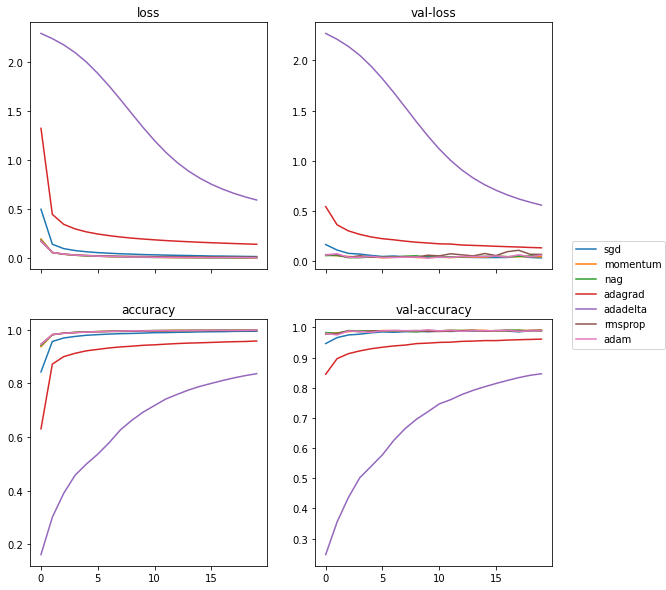

In [44]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex='col')
ax[0, 0].set_title("loss")
ax[0, 1].set_title("val-loss")
ax[1, 0].set_title("accuracy")
ax[1, 1].set_title("val-accuracy")

lines, labels = [], []
for optimizer_name in history_per_optimizer:
    history = history_per_optimizer[optimizer_name]
    ax[0, 0].plot(history.history['loss'])
    ax[0, 1].plot(history.history['val_loss'])
    ax[1, 0].plot(history.history['accuracy'])
    line = ax[1, 1].plot(history.history['val_accuracy'])
    lines.append(line[0])
    labels.append(optimizer_name)

fig.legend(lines, labels, loc='center right', borderaxespad=0.1)
plt.subplots_adjust(right=0.85)

## Conclusion
검증 세트의 최종 정확도는 인스턴스마다 크게 다르지 않지만, 우리는 더 좋은 최적화 도구로 훈련된 모델이 어떻게 더 빨리 수렴하는지 관찰할 수 있었다. 대부분의 경우, 정확도나 훈련 시간의 이득은 작은 크기임에도 매우 귀중할 수 있다.

다음에는 정규화 방법으로 실험하면서 현대적 훈련 기법을 탐구할 것이다.